## WTI Crude Oil Price Prediciton with SVR and LSTM Models

### 1. Introduction

### 1.1 Project Background - Use Case

Although many efforts have been put into green energy development because of the growing concern of climate changes, crude oil is still the most important commodity in the world, because human society heavily depends on energy and synthetic materials produced from fossil fuels. It is very essential to have a better understanding of the potential trend of crude oil prices for policymakers, regulators, investors and producers to manage crude oil production, monitor and evaluate the local and global economies. 

The oil price generally refers to the spot price of a barrel of benchmark crude oil — a reference price for buyers and sellers of crude oil such as West Texas Intermediate (WTI), Brent Crude, Dubai Crude, OPEC Reference Basket, Tapis crude, Bonny Light, Urals oil, Isthmus and Western Canadian Select (WCS). The spot price is the price for a one-time open market transaction for immediate delivery of a specific quantity of product at a specific location, where the commodity is purchased "on the spot" at current market rates. The price of a barrel of oil is different as a result of its grade—determined by factors such as its specific gravity or American Petroleum Institute (API) gravity and its sulphur content—and its location—for example, its proximity to tidewater and refineries. 

The crude oil prices are typically quoted at a particular location. In this project, machine learning (SVR) and deep learning (LSTM) models are developed for an Oil & Gas Commission in North America to predict the WTI spot price based on WTI historical oil price. The price of WTI is a crude stream produced in Texas and southern Oklahoma, which serves as a reference or "marker" for pricing a number of other crude streams and which is traded in the domestic spot market at Cushing, Oklahoma. 

*Sources of Reference: Wikipedia

### 1. 2 Install and Import Python Libraries for Data Retrieval, Analysis and Modeling


In [1]:
!pip install EIA_python
!pip install julian
!pip install statsmodels
!pip install texttable

import julian
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import keras
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
import sklearn.linear_model
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing import sequence
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input
from keras.models import Model
import h5py

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.dates as mdates

Using TensorFlow backend.


### 2. Dataset Retrieval, Data Assessment and Exploration

#### 2.1 Retrieve WTI Oil Price Dataset from EIA Database

In [2]:
# use eia api and api key to retrieve oil price data by series id and create a dataframe
import eia
import os

api_key = "xxxxxxxxxxxxxxxxxxx"
api = eia.API(api_key)

### Retrieve Data By Series ID ###
series_search = api.data_by_series(series = 'PET.RWTC.D')

for key,value in series_search.items():
    print(key,value)

wti = pd.DataFrame(series_search)

Cushing, OK WTI Spot Price FOB, Daily (Dollars per Barrel) {'2020 0518 18': 31.83, '2020 0515 15': 29.44, '2020 0514 14': 27.4, '2020 0513 13': 25.37, '2020 0512 12': 25.76, '2020 0511 11': 24.02, '2020 0508 08': 24.73, '2020 0507 07': 23.68, '2020 0506 06': 23.88, '2020 0505 05': 24.56, '2020 0504 04': 20.47, '2020 0501 01': 19.72, '2020 0430 30': 19.23, '2020 0429 29': 15.04, '2020 0428 28': 12.4, '2020 0427 27': 12.17, '2020 0424 24': 15.99, '2020 0423 23': 15.06, '2020 0422 22': 13.64, '2020 0421 21': 8.91, '2020 0420 20': -36.98, '2020 0417 17': 18.31, '2020 0416 16': 19.82, '2020 0415 15': 19.96, '2020 0414 14': 20.15, '2020 0413 13': 22.36, '2020 0409 09': 22.9, '2020 0408 08': 24.97, '2020 0407 07': 23.54, '2020 0406 06': 26.21, '2020 0403 03': 28.36, '2020 0402 02': 25.18, '2020 0401 01': 20.28, '2020 0331 31': 20.51, '2020 0330 30': 14.1, '2020 0327 27': 15.48, '2020 0326 26': 16.6, '2020 0325 25': 20.75, '2020 0324 24': 21.03, '2020 0323 23': 23.33, '2020 0320 20': 19.48, '2

#### 2.2 Assess Data Quality of Oil Price Dataset

In [3]:
# check the starting date of historical data
wti.head()

,"Cushing, OK WTI Spot Price FOB, Daily (Dollars per Barrel)"
1986 0102 02,25.56
1986 0103 03,26.00
1986 0106 06,26.53
1986 0107 07,25.85
1986 0108 08,25.87


In [4]:
# check the end date of dataset
wti.tail()

,"Cushing, OK WTI Spot Price FOB, Daily (Dollars per Barrel)"
2020 0512 12,25.76
2020 0513 13,25.37
2020 0514 14,27.40
2020 0515 15,29.44
2020 0518 18,31.83


In [5]:
# name index column as 'Date'
wti.index.name = 'Date'
wti

,"Cushing, OK WTI Spot Price FOB, Daily (Dollars per Barrel)"
Date,
1986 0102 02,25.56
1986 0103 03,26.00
1986 0106 06,26.53
1986 0107 07,25.85
1986 0108 08,25.87
...,...
2020 0512 12,25.76
2020 0513 13,25.37
2020 0514 14,27.40


In [6]:
# rename price column as 'WTI Oil Price (USD/Barrel)'
wti = wti.rename(columns = {'Cushing, OK WTI Spot Price FOB, Daily (Dollars per Barrel)':'WTI Oil Price (USD/Barrel)'})
wti

,WTI Oil Price (USD/Barrel)
Date,
1986 0102 02,25.56
1986 0103 03,26.00
1986 0106 06,26.53
1986 0107 07,25.85
1986 0108 08,25.87
...,...
2020 0512 12,25.76
2020 0513 13,25.37
2020 0514 14,27.40


In [7]:
# reset dateframe index and keep 'Date' column
wti = wti.reset_index(drop=False)
wti

,Date,WTI Oil Price (USD/Barrel)
0,1986 0102 02,25.56
1,1986 0103 03,26.00
2,1986 0106 06,26.53
3,1986 0107 07,25.85
4,1986 0108 08,25.87
...,...,...
8668,2020 0512 12,25.76
8669,2020 0513 13,25.37
8670,2020 0514 14,27.40
8671,2020 0515 15,29.44


In [8]:
# set 'Date' format to year-month-day format
from datetime import datetime
wti['Date'] =pd.to_datetime(wti['Date'].str[:-3], format='%Y %m%d')
wti

,Date,WTI Oil Price (USD/Barrel)
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87
...,...,...
8668,2020-05-12,25.76
8669,2020-05-13,25.37
8670,2020-05-14,27.40
8671,2020-05-15,29.44


In [9]:
# set 'Date' column as index again
wti_date_index = wti.set_index(['Date'])
wti_date_index

,WTI Oil Price (USD/Barrel)
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87
...,...
2020-05-12,25.76
2020-05-13,25.37
2020-05-14,27.40


In [10]:
# check summary statistics of wti dataframe
wti.describe()

,WTI Oil Price (USD/Barrel)
count,8673.000000
mean,44.067180
std,29.097389
min,-36.980000
25%,19.720000
50%,31.100000
75%,63.130000
max,145.310000


In [11]:
# check general information of dataframe: null values, dtypes, count
wti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8673 entries, 0 to 8672
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        8673 non-null   datetime64[ns]
 1   WTI Oil Price (USD/Barrel)  8673 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 135.6 KB


In [12]:
# check whether there are missing values by columns
print('Columns: Number of missing values')
print(wti_date_index.isnull().sum(axis=0))

Columns: Number of missing values
WTI Oil Price (USD/Barrel)    0
dtype: int64


#### 2.3 Data Exploration and Visulization of Oil Price Dataset

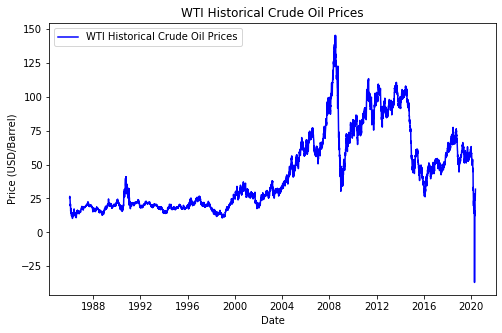

In [13]:
# for a time-series model, data is explored by visulizing the price against date and days
plt.figure(figsize=(8,5))
plt.plot(wti_date_index, color = 'blue', label = 'WTI Historical Crude Oil Prices')
plt.title('WTI Historical Crude Oil Prices')
plt.ylabel('Price (USD/Barrel)')
plt.xlabel('Date')
plt.legend()
plt.show()

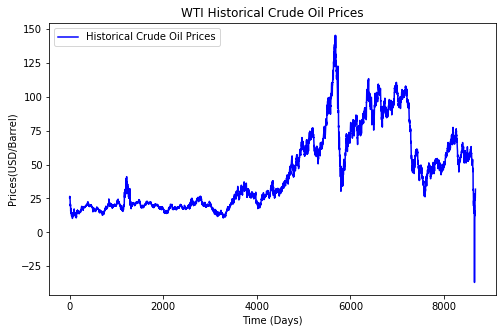

In [14]:
wti_plot = wti.iloc[:,1:2].values.astype(float)

plt.figure(figsize=(8,5))
plt.plot(wti_plot, color = 'blue', label = 'Historical Crude Oil Prices')
plt.title('WTI Historical Crude Oil Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Prices(USD/Barrel)')
plt.legend()
plt.show()

### 3. Predict WTI Crude Oil Price with Support Vector Regression (SVR)

#### 3.1 Prepare Dataset for SVR Modeling

In [15]:
# Convert date to julian date and add a new column
wti_date_index['Julian'] = wti_date_index.index.to_julian_date()
wti_julian = wti_date_index
wti_julian.head()

,WTI Oil Price (USD/Barrel),Julian
Date,,
1986-01-02,25.56,2446432.5
1986-01-03,26.00,2446433.5
1986-01-06,26.53,2446436.5
1986-01-07,25.85,2446437.5
1986-01-08,25.87,2446438.5


In [16]:
wti_julian_training = wti_julian[:-800]
wti_julian_training.head()

,WTI Oil Price (USD/Barrel),Julian
Date,,
1986-01-02,25.56,2446432.5
1986-01-03,26.00,2446433.5
1986-01-06,26.53,2446436.5
1986-01-07,25.85,2446437.5
1986-01-08,25.87,2446438.5


In [17]:
wti_julian_test = wti_julian[-800:]
wti_julian_test.tail()

,WTI Oil Price (USD/Barrel),Julian
Date,,
2020-05-12,25.76,2458981.5
2020-05-13,25.37,2458982.5
2020-05-14,27.40,2458983.5
2020-05-15,29.44,2458984.5
2020-05-18,31.83,2458987.5


In [18]:
X_training_svr = wti_julian_training["Julian"].to_frame()
y_training_svr = wti_julian_training["WTI Oil Price (USD/Barrel)"].to_frame()

X_test_svr = wti_julian_test["Julian"].to_frame()
y_test_svr = wti_julian_test["WTI Oil Price (USD/Barrel)"].to_frame()

#### 3.2 SVR Modeling and Testset Visulization

In [19]:
# create model
from sklearn.svm import SVR

oil_svr = SVR(kernel='rbf', C=1e3, gamma=0.001, epsilon=.1).fit(X_training_svr, y_training_svr) 

In [20]:
# get predicted results
y_pred_svr = list(map(lambda x: float(x), oil_svr.predict(X_test_svr)))

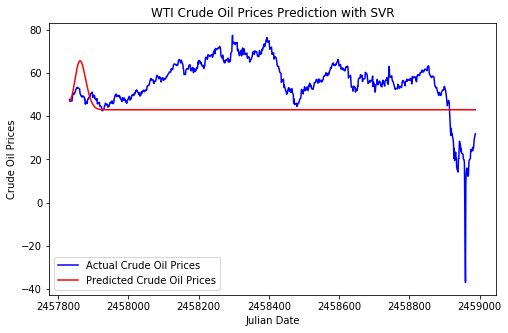

In [104]:
# plot test dataset
plt.figure(figsize=(8,5))
plt.plot(X_test_svr, y_test_svr, color = 'blue', label = 'Actual Crude Oil Prices')
plt.plot(X_test_svr, y_pred_svr, color = 'red', label = 'Predicted Crude Oil Prices')
plt.title('WTI Crude Oil Prices Prediction with SVR')
plt.xlabel('Julian Date')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

 #### 3.3 SVR Model Performance Evaluation

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [23]:
print("Mean absolute error: %.2f" % mean_absolute_error(y_pred_svr, y_test_svr))

Mean absolute error: 15.26


In [24]:
print("Mean_squared_error: %.2f" % mean_squared_error(y_pred_svr, y_test_svr))

Mean_squared_error: 298.36


In [25]:
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(y_pred_svr, y_test_svr) )

R2-score: -24.76


### 4 Predict WTI Crude Oil Price with LSTM Using Sequential API

#### 4.1 Preprocess Data for LSTM Modeling with Sequential API

In [26]:
# split dataset
sapi_training= wti[:-800]
sapi_training = sapi_training.drop(['Date'], axis = 1)

sapi_test = wti[-800:]
sapi_test = sapi_test.drop(['Date'], axis = 1)

In [27]:
sapi_training.head()

,WTI Oil Price (USD/Barrel)
0,25.56
1,26.00
2,26.53
3,25.85
4,25.87


In [28]:
sapi_training.tail()

,WTI Oil Price (USD/Barrel)
7868,47.95
7869,47.24
7870,48.34
7871,48.30
7872,48.34


In [29]:
sapi_test.head()

,WTI Oil Price (USD/Barrel)
7873,47.79
7874,47.02
7875,47.29
7876,47.00
7877,47.30


In [30]:
sapi_test.tail()

,WTI Oil Price (USD/Barrel)
8668,25.76
8669,25.37
8670,27.40
8671,29.44
8672,31.83


In [31]:
# feature scaling
scaler = MinMaxScaler()
sapi_training_scaled = scaler.fit_transform(sapi_training)
sapi_training_scaled

array([[0.11335703],
       [0.11661484],
       [0.12053902],
       ...,
       [0.2820228 ],
       [0.28172664],
       [0.2820228 ]])

In [32]:
# check training set shape
sapi_training_scaled.shape[0]

7873

In [33]:
# construct training dataset with 30 days look_back
look_back = 30 # or time steps? 
X_train_sapi = []
y_train_sapi= []

for i in range(look_back, sapi_training_scaled.shape[0]):
    X_train_sapi.append(sapi_training_scaled[i-look_back:i])
    y_train_sapi.append(sapi_training_scaled[i,0])
    
X_train_sapi, y_train_sapi =np.array(X_train_sapi), np.array(y_train_sapi)

In [34]:
# check the ship of training dataset
X_train_sapi.shape, y_train_sapi.shape

((7843, 30, 1), (7843,))

#### 4.2 Build LSTM Model with Sequential API

In [35]:
# define model using sequential API. Influence of layers on prediction was investigated, but wasn't included in this notebook

regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train_sapi.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 80, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

# initialising the LSTM model with mse loss function
# adam is fast starting off and then gets slower and more precise
# mse -> mean squared error loss function
regressor.compile(optimizer='adam', loss='mse')

# check model summary
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 60)            26640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 60)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 80)            45120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 80)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 80)               

In [36]:
# fit model by inverstigating various values of epochs, batch_size
regressor.fit(X_train_sapi, y_train_sapi, epochs = 30, batch_size = 32)

Epoch 1/30
7843/7843 [==============================] - 27s 3ms/step - loss: 0.0092
Epoch 2/30
7843/7843 [==============================] - 23s 3ms/step - loss: 0.0037
Epoch 3/30
7843/7843 [==============================] - 23s 3ms/step - loss: 0.0034: 9s  - ETA: 1s - 
Epoch 4/30
7843/7843 [==============================] - 23s 3ms/step - loss: 0.0029
Epoch 5/30
7843/7843 [==============================] - 21s 3ms/step - loss: 0.0028
Epoch 6/30
7843/7843 [==============================] - 21s 3ms/step - loss: 0.0026
Epoch 7/30
7843/7843 [==============================] - 21s 3ms/step - loss: 0.0027
Epoch 8/30
7843/7843 [==============================] - 23s 3ms/step - loss: 0.0025
Epoch 9/30
7843/7843 [==============================] - 23s 3ms/step - loss: 0.0024
Epoch 10/30
7843/7843 [==============================] - 23s 3ms/step - loss: 0.0024
Epoch 11/30
7843/7843 [==============================] - 23s 3ms/step - loss: 0.0023
Epoch 12/30
7843/7843 [==============================] -

#### 4.3 Test LSTM Sequential Model

In [37]:
# check the last 30 days of training dataset
sapi_training.tail(30)

,WTI Oil Price (USD/Barrel)
7843,53.81
7844,53.01
7845,52.19
7846,52.37
7847,52.99
7848,53.84
7849,52.96
7850,53.21
7851,53.11
7852,53.41


In [38]:
# get the last 30 days of training dataset
past_30_days = sapi_training.tail(30)

In [39]:
# append last 30 days of training dataset to test dataset
df_test_sapi = past_30_days.append(sapi_test, ignore_index = True)
df_test_sapi

,WTI Oil Price (USD/Barrel)
0,53.81
1,53.01
2,52.19
3,52.37
4,52.99
...,...
825,25.76
826,25.37
827,27.40
828,29.44


In [40]:
# feature scaling of test dataset
inputs_sapi = scaler.transform(df_test_sapi)
inputs_sapi

array([[ 0.32252332],
       [ 0.31660003],
       [ 0.31052865],
       [ 0.31186139],
       [ 0.31645195],
       [ 0.32274545],
       [ 0.31622982],
       [ 0.31808085],
       [ 0.31734044],
       [ 0.31956168],
       [ 0.31956168],
       [ 0.32407819],
       [ 0.3210425 ],
       [ 0.32748408],
       [ 0.32385606],
       [ 0.32422627],
       [ 0.32393011],
       [ 0.32259736],
       [ 0.31378647],
       [ 0.31896935],
       [ 0.31793277],
       [ 0.31415667],
       [ 0.29305494],
       [ 0.28505849],
       [ 0.27987561],
       [ 0.2791352 ],
       [ 0.27387828],
       [ 0.2820228 ],
       [ 0.28172664],
       [ 0.2820228 ],
       [ 0.27795054],
       [ 0.27224937],
       [ 0.27424848],
       [ 0.27210129],
       [ 0.27432252],
       [ 0.27224937],
       [ 0.28217089],
       [ 0.29038946],
       [ 0.29653487],
       [ 0.29831186],
       [ 0.29616467],
       [ 0.30164371],
       [ 0.30275433],
       [ 0.3068266 ],
       [ 0.3109729 ],
       [ 0

In [41]:
# construct test dataset
X_test_sapi = []
y_test_sapi = []

for i in range (look_back, inputs_sapi.shape[0]):
    X_test_sapi.append(inputs_sapi[i-look_back:i])
    y_test_sapi.append(inputs_sapi[i, 0])
    
X_test_sapi, y_test_sapi =np.array(X_test_sapi), np.array(y_test_sapi)
X_test_sapi.shape, y_test_sapi.shape

((800, 30, 1), (800,))

In [42]:
# predicted values of test dataset
y_pred_sapi = regressor.predict(X_test_sapi)
y_pred_sapi

array([[0.26670447],
       [0.26290563],
       [0.2602107 ],
       [0.25837013],
       [0.25710684],
       [0.25624907],
       [0.25565964],
       [0.25546604],
       [0.25614175],
       [0.2582798 ],
       [0.2620729 ],
       [0.2672475 ],
       [0.27343312],
       [0.27989703],
       [0.28610522],
       [0.29178834],
       [0.29705116],
       [0.3019929 ],
       [0.3064149 ],
       [0.31001395],
       [0.31231448],
       [0.31306964],
       [0.31191814],
       [0.30904037],
       [0.3047341 ],
       [0.29929036],
       [0.29326862],
       [0.28725034],
       [0.28167242],
       [0.27692798],
       [0.27320614],
       [0.2702805 ],
       [0.2679256 ],
       [0.26554215],
       [0.26285508],
       [0.2598891 ],
       [0.25677413],
       [0.25395086],
       [0.25188544],
       [0.2508925 ],
       [0.25134897],
       [0.25329444],
       [0.25647146],
       [0.26053444],
       [0.2653177 ],
       [0.27081117],
       [0.27675867],
       [0.282

In [43]:
# scaler value
scaler.scale_

array([0.00740412])

In [44]:
# inversed scaler
scale = 1/0.00740412
scale

135.059939601195

In [45]:
# predicted oil pirce values and oil pirce of test dataset
y_pred_sapi = y_pred_sapi*scale
y_test_sapi = y_test_sapi*scale

In [46]:
y_pred_sapi

array([[36.021088 ],
       [35.50802  ],
       [35.14404  ],
       [34.895454 ],
       [34.724834 ],
       [34.608982 ],
       [34.529373 ],
       [34.503227 ],
       [34.59449  ],
       [34.883255 ],
       [35.39555  ],
       [36.09443  ],
       [36.92986  ],
       [37.802876 ],
       [38.641354 ],
       [39.408916 ],
       [40.119713 ],
       [40.78714  ],
       [41.384377 ],
       [41.870464 ],
       [42.181175 ],
       [42.283165 ],
       [42.127644 ],
       [41.73897  ],
       [41.15737  ],
       [40.42214  ],
       [39.60884  ],
       [38.796013 ],
       [38.04266  ],
       [37.401875 ],
       [36.899204 ],
       [36.50407  ],
       [36.186012 ],
       [35.864105 ],
       [35.50119  ],
       [35.100605 ],
       [34.679897 ],
       [34.298588 ],
       [34.01963  ],
       [33.885525 ],
       [33.947178 ],
       [34.20993  ],
       [34.63902  ],
       [35.187763 ],
       [35.833794 ],
       [36.57574  ],
       [37.37901  ],
       [38.17

In [47]:
y_test_sapi

array([ 37.53998321,  36.76998356,  37.03998344,  36.74998357,
        37.04998343,  36.76998356,  38.10998296,  39.21998246,
        40.04998209,  40.28998198,  39.99998211,  40.73998178,
        40.88998171,  41.43998147,  41.99998122,  42.80998086,
        43.12998071,  42.86998083,  42.9399808 ,  42.36998105,
        42.20998112,  40.239982  ,  40.00998211,  39.38998238,
        38.64998272,  38.96998257,  38.96998257,  38.70998269,
        39.05998253,  38.57998275,  37.39998327,  37.53998321,
        35.29998421,  35.97998391,  36.20998381,  35.58998408,
        37.02998344,  37.5599832 ,  37.57998319,  38.60998273,
        38.38998283,  38.78998265,  39.10998251,  40.06998208,
        40.55998186,  40.86998172,  40.73998178,  38.31998286,
        39.32998241,  39.37998239,  38.03998299,  38.06998298,
        37.42998326,  37.14998339,  37.87998306,  35.5499841 ,
        35.42998416,  35.56998409,  35.84998397,  36.15998383,
        34.53998455,  34.2199847 ,  34.47998458,  33.98

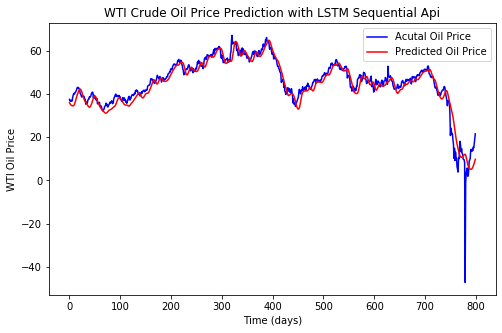

In [105]:
# visulizing the test data
# plt.plot(wti['WTI'], color = 'red', label = "Real Oil Price")
plt.figure(figsize=(8,5))
plt.plot(y_test_sapi, color = 'blue', label = "Acutal Oil Price")
plt.plot(y_pred_sapi, color = 'red',label = 'Predicted Oil Price')
plt.title('WTI Crude Oil Price Prediction with LSTM Sequential Api')
plt.xlabel('Time (days)')
plt.ylabel('WTI Oil Price')
plt.legend()
plt.show()

#### 4.4 Performance valuation of LSTM Squential Model in Crude Oil Price Prediction

In [49]:
print("Mean absolute error: %.2f" % mean_absolute_error(y_pred_sapi, y_test_sapi))

Mean absolute error: 2.36


In [50]:
print("Mean_squared_error: %.2f" % mean_squared_error(y_pred_sapi, y_test_sapi))

Mean_squared_error: 13.98


In [51]:
print("R2-score: %.2f" % r2_score(y_pred_sapi, y_test_sapi) )

R2-score: 0.89


### 5 Predict WTI Crude Oil Price with LSTM Model Using Functional API

#### 5.1 Preprocess Training Dataset for LSTM Model Prediction with Functional API 

In [78]:
# define the batch size, epochs and timesteps
batch_size = 64
epochs = 160
timesteps = 30

In [79]:
# split the oil price dataset at a 10% ratio
length = len(wti)
print(length)
length *= 1 - 0.1
print(length)

8673
7805.7


In [80]:
# find the remainder of dataset length divided by batch size
7805%64.0

61.0

In [81]:
# find the maximum length with a remainder 0 after being divided by batch size
7744%64.0

0.0

In [82]:
# define a function to get the length of training dataset
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))

length = get_train_length(wti, batch_size, 0.1)
print(length)

7744
7744


In [83]:
#Adding timesteps * 2
upper_train = length + timesteps*2
wti_train = wti[0:upper_train]
training_fapi = wti_train.iloc[:,1:2].values
training_fapi.shape

(7804, 1)

In [84]:
# Feature Scaling. Scale between 0 and 1. The weights are esier to find.
scaler = MinMaxScaler()
training_fapi_scaled = scaler.fit_transform(np.float64(training_fapi))
training_fapi_scaled.shape

(7804, 1)

In [85]:
# construct a training set for LSTM Model using Functional API

X_train_fapi = []
y_train_fapi = []

# Creating a data structure with n timesteps
print(length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train_fapi.append(training_fapi_scaled[i-timesteps:i,0])
    y_train_fapi.append(training_fapi_scaled[i:i+timesteps,0])

print(len(X_train_fapi))
print(len(y_train_fapi))

#create X_train matrix
#30 items per array (timestep) 
print(X_train_fapi[0:2])
print(np.array(X_train_fapi).shape)

#create Y_train matrix
#30 items per array (timestep) 
print(y_train_fapi[0:2])
print(np.array(y_train_fapi).shape)

7774
7744
7744
[array([0.11335703, 0.11661484, 0.12053902, 0.11550422, 0.1156523 ,
       0.11683696, 0.1140234 , 0.10980305, 0.1089886 , 0.11054346,
       0.10165852, 0.09906708, 0.08203761, 0.07670665, 0.07404117,
       0.07167185, 0.06811787, 0.07863172, 0.06811787, 0.06930253,
       0.06908041, 0.06441582, 0.05308752, 0.03946394, 0.04464682,
       0.04701614, 0.05516067, 0.04834888, 0.04464682, 0.0406486 ]), array([0.11661484, 0.12053902, 0.11550422, 0.1156523 , 0.11683696,
       0.1140234 , 0.10980305, 0.1089886 , 0.11054346, 0.10165852,
       0.09906708, 0.08203761, 0.07670665, 0.07404117, 0.07167185,
       0.06811787, 0.07863172, 0.06811787, 0.06930253, 0.06908041,
       0.06441582, 0.05308752, 0.03946394, 0.04464682, 0.04701614,
       0.05516067, 0.04834888, 0.04464682, 0.0406486 , 0.04575744])]
(7744, 30)
[array([0.04575744, 0.04279579, 0.03294832, 0.03576188, 0.02872797,
       0.02502591, 0.03280024, 0.03280024, 0.03235599, 0.02813564,
       0.02206427, 0.01280912,

In [86]:
# reshaping training dataset
X_train_fapi, y_train_fapi = np.array(X_train_fapi), np.array(y_train_fapi)
X_train_fapi = np.reshape(X_train_fapi, (X_train_fapi.shape[0], X_train_fapi.shape[1], 1))
y_train_fapi = np.reshape(y_train_fapi, (y_train_fapi.shape[0], y_train_fapi.shape[1], 1))
print(X_train_fapi.shape)
print(y_train_fapi.shape)

(7744, 30, 1)
(7744, 30, 1)


#### 5.2 Design LSTM Model Using Functional API

In [87]:
# initialising the LSTM Model with MSE Loss Function

inputs_1_mse = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mse = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mse)
lstm_2_mse = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mse)

output_1_mse = Dense(units = 1)(lstm_2_mse)

regressor_mse = Model(inputs=inputs_1_mse, outputs = output_1_mse)

#mse -> mean squared error as loss function
regressor_mse.compile(optimizer='adam', loss = 'mse')
regressor_mse.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_7 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_8 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_3 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [88]:
# 1st LSTM layer paramters
parameters = 4 * 10 * (1 + 10 + 1)
print(parameters)

480


In [89]:
# 2nd LSTM layer parameters
parameters = 4 * 10 * (10 + 10 + 1)
print(parameters)

840


In [90]:
for i in range(epochs):
    print("Epoch: " + str(i))
    # run through all data but the cell, hidden state are used for the next batch.
    # influence of the number of epochs were investigated.
    regressor_mse.fit(X_train_fapi, y_train_fapi, shuffle=False, epochs = 1, batch_size = batch_size)
    # resets only the states but the weights, cell and hidden are kept.
    regressor_mse.reset_states()

Epoch: 0
Epoch 1/1
7744/7744 [==============================] - 4s 530us/step - loss: 0.0054
Epoch: 1
Epoch 1/1
7744/7744 [==============================] - 4s 459us/step - loss: 0.0060
Epoch: 2
Epoch 1/1
7744/7744 [==============================] - 3s 451us/step - loss: 0.0061
Epoch: 3
Epoch 1/1
7744/7744 [==============================] - 4s 487us/step - loss: 0.0059
Epoch: 4
Epoch 1/1
7744/7744 [==============================] - 3s 445us/step - loss: 0.0055
Epoch: 5
Epoch 1/1
7744/7744 [==============================] - 3s 442us/step - loss: 0.0052
Epoch: 6
Epoch 1/1
7744/7744 [==============================] - 4s 457us/step - loss: 0.0049
Epoch: 7
Epoch 1/1
7744/7744 [==============================] - 4s 454us/step - loss: 0.0046
Epoch: 8
Epoch 1/1
7744/7744 [==============================] - 4s 460us/step - loss: 0.0044
Epoch: 9
Epoch 1/1
7744/7744 [==============================] - 4s 460us/step - loss: 0.0042
Epoch: 10
Epoch 1/1
7744/7744 [==============================] - 4s 46

In [91]:
#save model
regressor_mse.save("my_opmodel.h5")
print("Saved model to local")

Saved model to local


In [92]:
#load model
regressor_mse = load_model("my_opmodel.h5")

#### 5.3 Construct Test Dataset

In [93]:
# define a function to get the length of training dataset
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [94]:
test_length = get_test_length(wti, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

8508
8572
8572
768


In [95]:
print(upper_train, upper_test, len(wti))

7804 8632 8673


In [96]:
#subsetting
wti_test_fapi = wti[upper_train:upper_test] 
test_fapi = wti_test_fapi.iloc[:,1:2].values

#scaling
scaled_real_bcg_values_test = scaler.fit_transform(np.float64(test_fapi))

#creating input data
X_test_fapi = []
for i in range(timesteps, testset_length + timesteps):
    X_test_fapi.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test_fapi = np.array(X_test_fapi)


#reshaping
X_test_fapi = np.reshape(X_test_fapi, (X_test_fapi.shape[0], X_test_fapi.shape[1], 1))

In [97]:
X_test_fapi.shape

(768, 30, 1)

#### 5.4 Predict and Visualize of the Testset WTI Crude Oil Price

In [98]:
# prediction
predicted_bcg_values_test_mse = regressor_mse.predict(X_test_fapi, batch_size=batch_size)
regressor_mse.reset_states()

print(predicted_bcg_values_test_mse.shape)

# reshaping
predicted_bcg_values_test_mse = np.reshape(predicted_bcg_values_test_mse, 
                                       (predicted_bcg_values_test_mse.shape[0], 
                                        predicted_bcg_values_test_mse.shape[1]))
print(predicted_bcg_values_test_mse.shape)

# inverse transform
predicted_bcg_values_test_mse = scaler.inverse_transform(predicted_bcg_values_test_mse)

# creating y_test data
y_pred_fapi = []

for j in range(0, testset_length - timesteps):
    y_pred_fapi = np.append(y_pred_fapi, predicted_bcg_values_test_mse[j, timesteps-1])

# reshaping
y_pred_fapi = np.reshape(y_pred_fapi, (y_pred_fapi.shape[0], 1))

print(y_pred_fapi.shape)

(768, 30, 1)
(768, 30)
(738, 1)


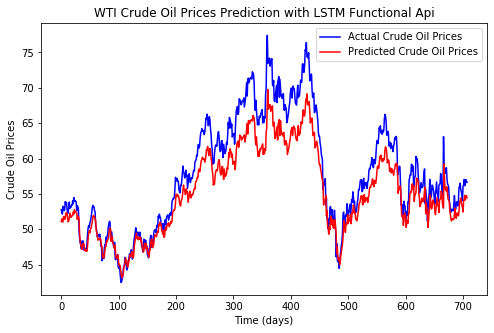

In [106]:
# visualising the results
plt.figure(figsize=(8,5))
plt.plot(test_fapi[timesteps:len(y_pred_fapi)].astype(float), color = 'blue', label = 'Actual Crude Oil Prices')
plt.plot(y_pred_fapi[0:len(y_pred_fapi) - timesteps], color = 'red', label = 'Predicted Crude Oil Prices')
plt.title('WTI Crude Oil Prices Prediction with LSTM Functional Api')
plt.xlabel('Time (days)')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

#### 5.5 Evaluate the Performance of LSTM Model in Predicting the Oil Price Using Functional API

In [100]:
print("Mean absolute error: %.2f" % 
      mean_absolute_error(test_fapi[timesteps:len(y_pred_fapi)], y_pred_fapi[0:len(y_pred_fapi) - timesteps]))

Mean absolute error: 2.70


In [101]:
print("Mean_squared_error: %.2f" % 
      mean_squared_error(test_fapi[timesteps:len(y_pred_fapi)], y_pred_fapi[0:len(y_pred_fapi) - timesteps]))

Mean_squared_error: 11.12


In [102]:
print("R2-score: %.2f" % 
      r2_score(test_fapi[timesteps:len(y_pred_fapi)], y_pred_fapi[0:len(y_pred_fapi) - timesteps]) )

R2-score: 0.82
